# Sales Forecasting Analysis

## Task
Perform a comprehensive sales forecasting analysis using `train.csv` and `store.csv` datasets. This involves loading and merging the data, cleaning it, engineering new features, conducting exploratory data analysis and statistical analysis, training a Random Forest Regressor model, evaluating its performance, and visualizing key results.

## Load and Merge Data

### Subtask:
Load the `train.csv` and `store.csv` datasets into pandas DataFrames. Merge these two DataFrames on the 'Store' column. Convert the 'Date' column to a datetime object for easier time-series analysis.

**Reasoning**: Load the train.csv and store.csv files into pandas DataFrames, then merge them based on the 'Store' column, and finally convert the 'Date' column to datetime objects for time-series analysis.

In [7]:
import pandas as pd

# Load the datasets, specifying dtype for 'StateHoliday' to avoid DtypeWarning
train_df = pd.read_csv("https://raw.githubusercontent.com/atikshahriaopu/Simulation/refs/heads/main/final%20project/train.csv")
store_df = pd.read_csv("https://raw.githubusercontent.com/atikshahriaopu/Simulation/refs/heads/main/final%20project/store.csv")

# Merge the DataFrames on the 'Store' column
merged_df = pd.merge(train_df, store_df, on='Store', how='left')

# Convert the 'Date' column to datetime objects
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

print("Merged DataFrame head:")
print(merged_df.head())

print("\nMerged DataFrame info:")
merged_df.info()

/tmp/ipython-input-2314458432.py:4: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv("https://raw.githubusercontent.com/atikshahriaopu/Simulation/refs/heads/main/final%20project/train.csv")


Merged DataFrame head:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0       0   
1  

## Data Cleaning

### Subtask:
Remove rows from the merged dataset where stores were closed (indicated by 'Open' == 0) as these won't contribute to sales forecasting. Fill missing values in store metadata columns (e.g., 'CompetitionDistance', 'Promo2SinceWeek', 'Promo2SinceYear', etc.) using appropriate strategies (e.g., median, mode, or a constant). Ensure all columns have the correct data types for subsequent analysis.

**Reasoning**: I will perform the requested data cleaning operations: removing closed store entries, filling missing numerical values with medians or zeros, and filling missing categorical values with a specific string.

In [8]:
import numpy as np

# 1. Remove rows where 'Open' is 0
merged_df = merged_df[merged_df['Open'] != 0]

# 2. Fill missing 'CompetitionDistance' with the median
median_competition_distance = merged_df['CompetitionDistance'].median()
merged_df['CompetitionDistance'] = merged_df['CompetitionDistance'].fillna(median_competition_distance)

# 3. Fill missing competition and promo columns with 0.0
merged_df['CompetitionOpenSinceMonth'] = merged_df['CompetitionOpenSinceMonth'].fillna(0.0)
merged_df['CompetitionOpenSinceYear'] = merged_df['CompetitionOpenSinceYear'].fillna(0.0)
merged_df['Promo2SinceWeek'] = merged_df['Promo2SinceWeek'].fillna(0.0)
merged_df['Promo2SinceYear'] = merged_df['Promo2SinceYear'].fillna(0.0)

# 4. Fill missing 'PromoInterval' with 'No Promo2'
merged_df['PromoInterval'] = merged_df['PromoInterval'].fillna('No Promo2')

# Convert appropriate columns to integer type
merged_df['CompetitionOpenSinceMonth'] = merged_df['CompetitionOpenSinceMonth'].astype(int)
merged_df['CompetitionOpenSinceYear'] = merged_df['CompetitionOpenSinceYear'].astype(int)
merged_df['Promo2SinceWeek'] = merged_df['Promo2SinceWeek'].astype(int)
merged_df['Promo2SinceYear'] = merged_df['Promo2SinceYear'].astype(int)

print("Merged DataFrame head after cleaning:")
print(merged_df.head())

print("\nMerged DataFrame info after cleaning:")
merged_df.info()

Merged DataFrame head after cleaning:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                          9                      2008

## Feature Engineering

### Subtask:
Create new features from the 'Date' column such as 'Year', 'Month', 'Day', 'WeekOfYear', and 'DayOfYear'. Additionally, derive 'CompetitionOpen' and 'Promo2Open' features to represent the duration in months/weeks since the competition opened or Promo2 started. Convert 'StateHoliday' to numerical representation for modeling purposes.

**Reasoning**: Creating time-based features and calculating competition and promo durations will provide more predictive power to the model.

In [9]:
# Create time-based features
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['WeekOfYear'] = merged_df['Date'].dt.isocalendar().week.astype(int)
merged_df['DayOfYear'] = merged_df['Date'].dt.dayofyear

# Derive 'CompetitionOpen' in months
merged_df['CompetitionOpen'] = 12 * (merged_df['Year'] - merged_df['CompetitionOpenSinceYear']) + \
                                (merged_df['Month'] - merged_df['CompetitionOpenSinceMonth'])
merged_df.loc[merged_df['CompetitionOpenSinceYear'] == 0, 'CompetitionOpen'] = 0

# Derive 'Promo2Open' in weeks
merged_df['Promo2Open'] = 52 * (merged_df['Year'] - merged_df['Promo2SinceYear']) + \
                           (merged_df['WeekOfYear'] - merged_df['Promo2SinceWeek'])
merged_df.loc[merged_df['Promo2SinceYear'] == 0, 'Promo2Open'] = 0

# Convert 'StateHoliday' to numerical representation
merged_df['StateHoliday'] = merged_df['StateHoliday'].astype(str).map({'0': 0, 'a': 1, 'b': 2, 'c': 3})
merged_df['StateHoliday'] = merged_df['StateHoliday'].fillna(0).astype(int)

print("Merged DataFrame head after feature engineering:")
print(merged_df.head())

print("\nMerged DataFrame info after feature engineering:")
merged_df.info()

Merged DataFrame head after feature engineering:
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo  StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1             0   
1      2          5 2015-07-31   6064        625     1      1             0   
2      3          5 2015-07-31   8314        821     1      1             0   
3      4          5 2015-07-31  13995       1498     1      1             0   
4      5          5 2015-07-31   4822        559     1      1             0   

   SchoolHoliday StoreType  ... Promo2SinceWeek  Promo2SinceYear  \
0              1         c  ...               0                0   
1              1         a  ...              13             2010   
2              1         a  ...              14             2011   
3              1         c  ...               0                0   
4              1         a  ...               0                0   

     PromoInterval  Year  Month  Day  WeekOfYear DayOfYear  Competi

## Exploratory Data Analysis (EDA)

### Subtask:
Perform an initial EDA to understand the dataset. Plot average sales over time to observe trends. Compare sales performance during promotion periods versus non-promotion periods. Visualize monthly and seasonal trends in sales using appropriate plots.

**Reasoning**: Visualizing the data helps identify patterns, trends, and relationships that will inform our modeling approach.

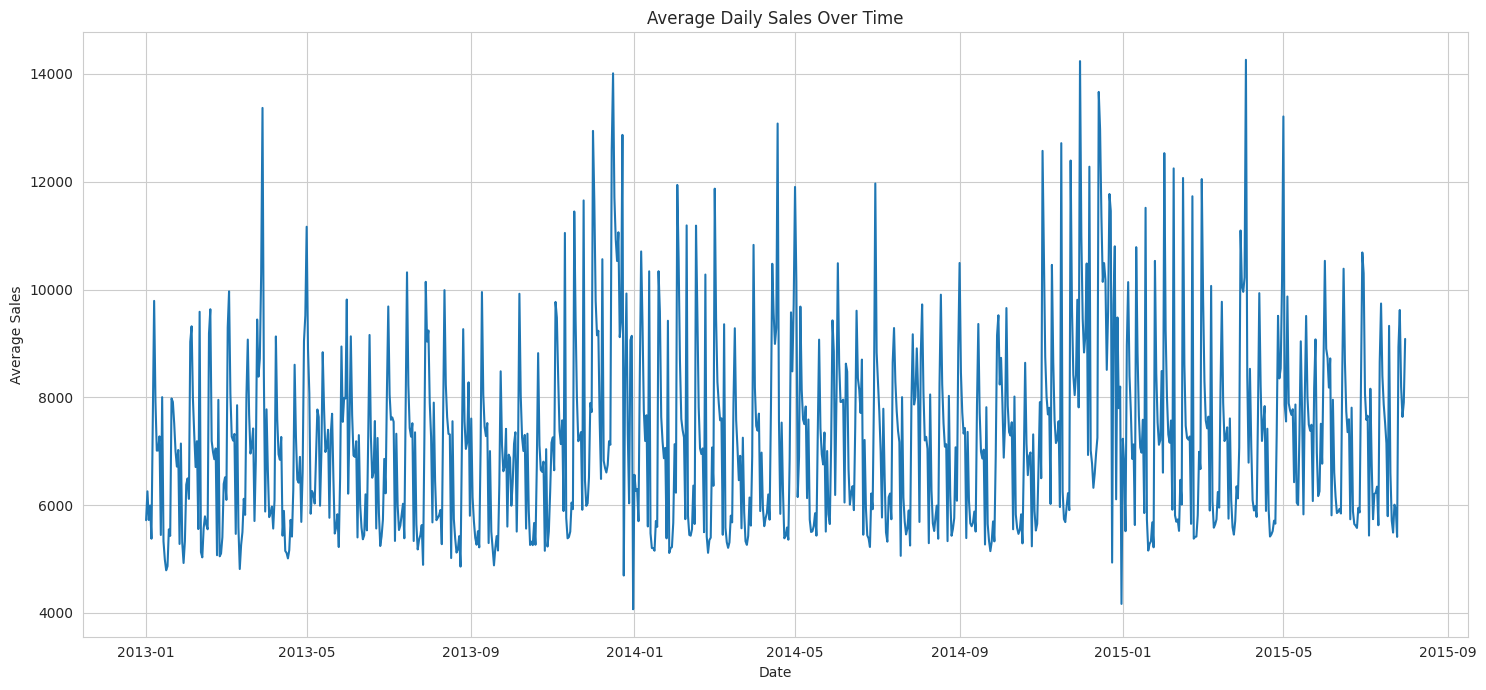

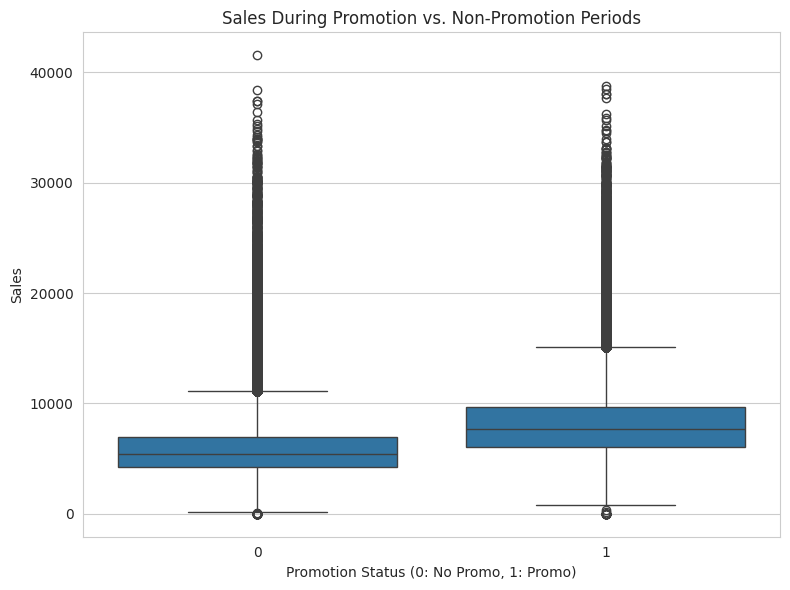

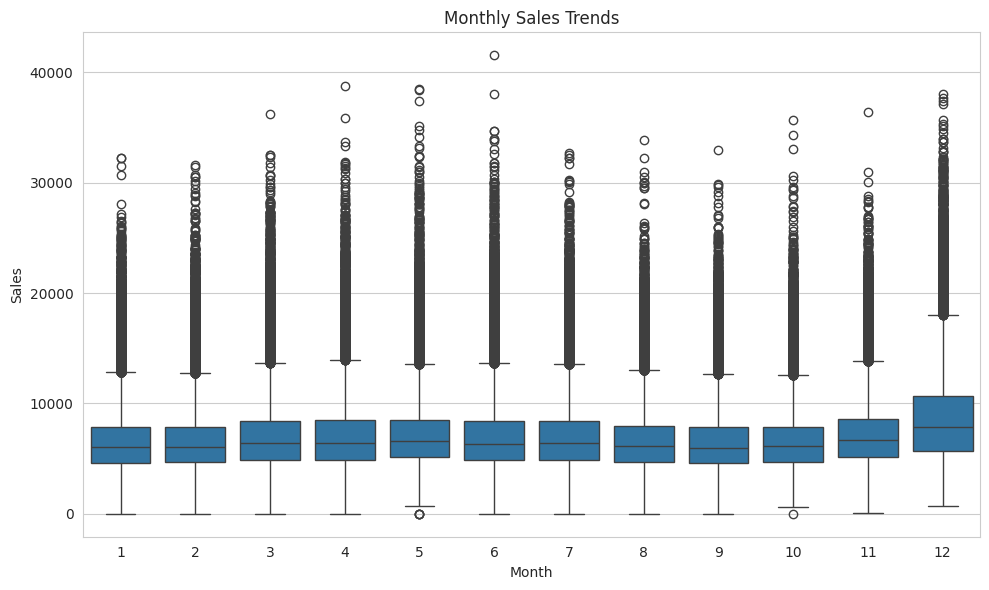

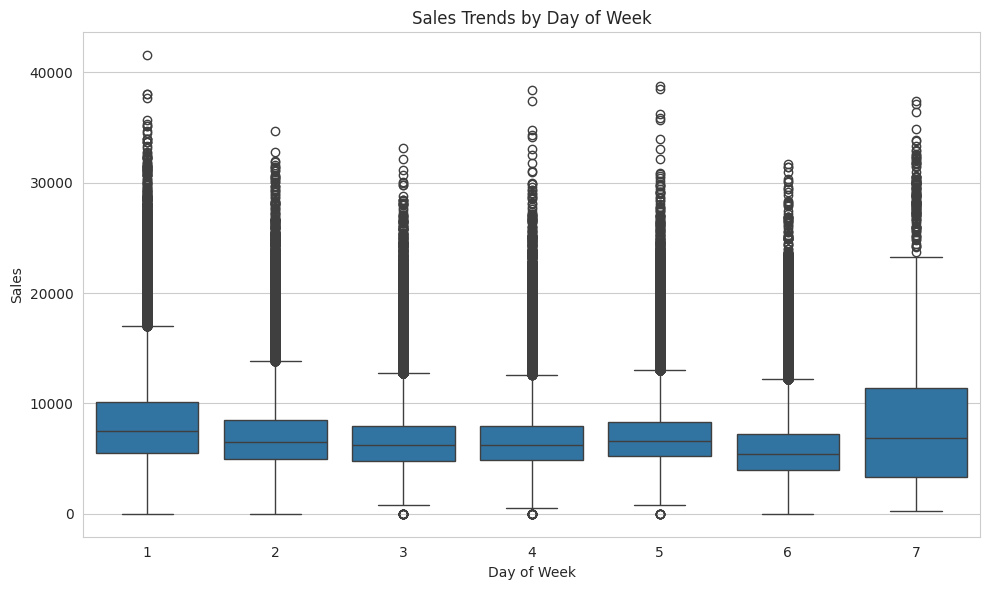

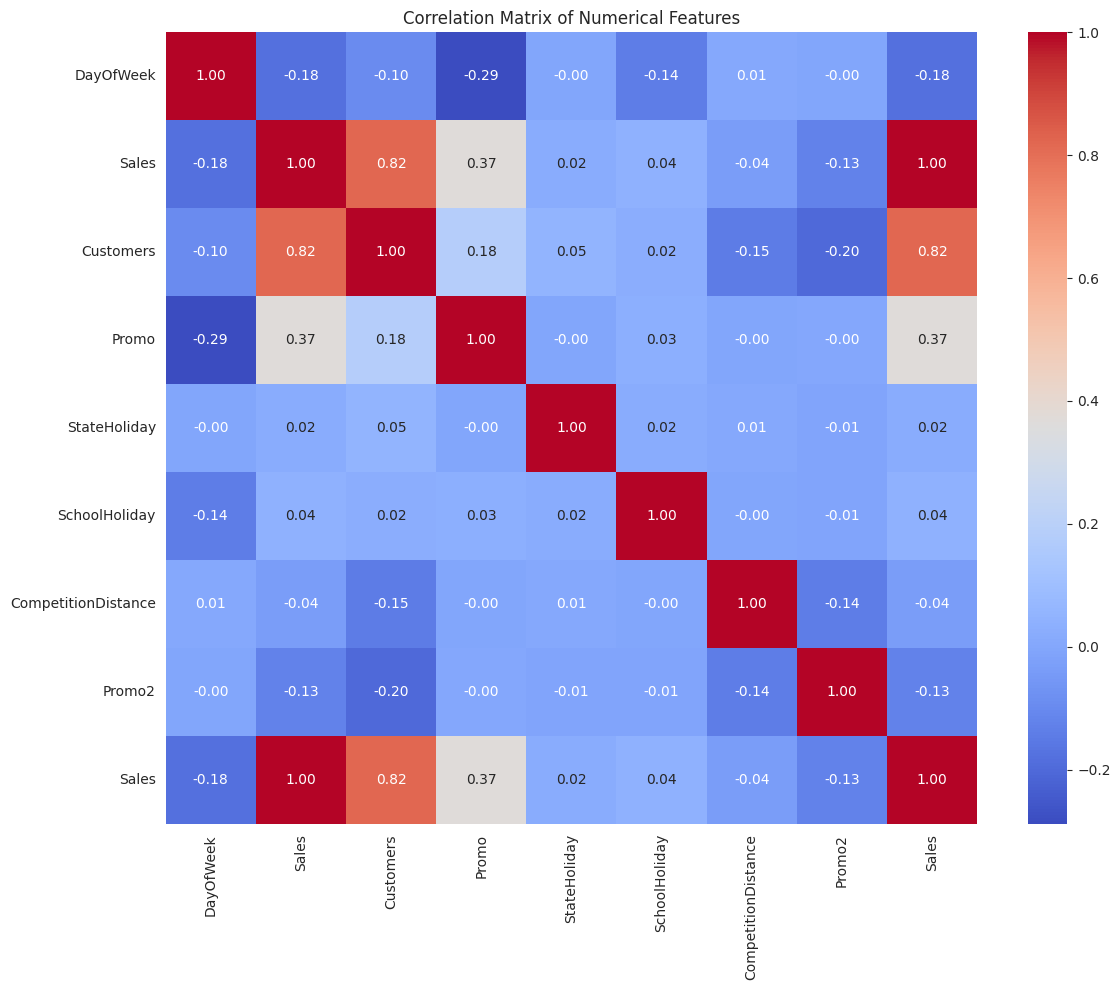

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

# 1. Average Daily Sales Over Time
avg_daily_sales = merged_df.groupby('Date')['Sales'].mean().reset_index()
plt.figure(figsize=(15, 7))
sns.lineplot(x='Date', y='Sales', data=avg_daily_sales)
plt.title('Average Daily Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Average Sales')
plt.tight_layout()
plt.show()

# 2. Sales During Promotion vs. Non-Promotion Periods
plt.figure(figsize=(8, 6))
sns.boxplot(x='Promo', y='Sales', data=merged_df)
plt.title('Sales During Promotion vs. Non-Promotion Periods')
plt.xlabel('Promotion Status (0: No Promo, 1: Promo)')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# 3. Monthly Sales Trends
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Sales', data=merged_df)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# 4. Sales Trends by Day of Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='DayOfWeek', y='Sales', data=merged_df)
plt.title('Sales Trends by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

# 5. Correlation Matrix
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()
features_for_correlation = [col for col in numerical_cols if col not in ['Store', 'Open', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'DayOfYear', 'CompetitionOpen', 'Promo2Open']]
features_for_correlation.append('Sales')

correlation_matrix = merged_df[features_for_correlation].corr(numeric_only=True)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()

## Statistical Analysis

### Subtask:
Conduct a t-test to compare the mean sales during promotion periods against non-promotion periods, displaying the p-value and interpreting its significance.

**Reasoning**: Statistical testing provides rigorous validation of observed patterns in the data.

In [11]:
from scipy.stats import ttest_ind

print("--- T-test: Sales during Promotion vs. Non-Promotion Periods ---")
sales_promo = merged_df[merged_df['Promo'] == 1]['Sales']
sales_non_promo = merged_df[merged_df['Promo'] == 0]['Sales']

t_stat, p_value_ttest = ttest_ind(sales_promo, sales_non_promo, equal_var=False)

print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value_ttest:.3e}")

alpha = 0.05
if p_value_ttest < alpha:
    print("Interpretation: The p-value is less than 0.05, indicating a statistically significant difference in mean sales between promotion and non-promotion periods.")
else:
    print("Interpretation: The p-value is greater than 0.05, indicating no statistically significant difference in mean sales between promotion and non-promotion periods.")

--- T-test: Sales during Promotion vs. Non-Promotion Periods ---
T-statistic: 356.64
P-value: 0.000e+00
Interpretation: The p-value is less than 0.05, indicating a statistically significant difference in mean sales between promotion and non-promotion periods.


## Prepare Data for Modeling

### Subtask:
Select the engineered features and 'Sales' as the target variable. Split the dataset into training and testing sets (80/20 ratio). Apply one-hot encoding to categorical variables.

**Reasoning**: Proper data preparation ensures the model receives appropriately formatted input.

In [12]:
from sklearn.model_selection import train_test_split

# Define features and target
X = merged_df.drop(['Sales', 'Date'], axis=1)
y = merged_df['Sales']

# Identify categorical columns for one-hot encoding
categorical_cols = ['StoreType', 'Assortment', 'PromoInterval']

# Apply one-hot encoding
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

print("\nFirst 5 rows of X_train:")
print(X_train.head())

Shape of X_train: (675513, 28)
Shape of X_test: (168879, 28)
Shape of y_train: (675513,)
Shape of y_test: (168879,)

First 5 rows of X_train:
         Store  DayOfWeek  Customers  Open  Promo  StateHoliday  \
947192     228          1        683     1      1             0   
512268     154          6        662     1      0             0   
1008918    629          2        661     1      1             0   
521587     553          5        581     1      1             0   
836684     105          2        485     1      0             0   

         SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
947192               0              10800.0                          0   
512268               0              16420.0                          0   
1008918              0                510.0                          7   
521587               0               3040.0                          9   
836684               0               6190.0                          0   

         C

## Modeling with Random Forest

### Subtask:
Instantiate and train a Random Forest Regressor model. Extract and display feature importance scores.

**Reasoning**: Random Forest provides robust predictions and feature importance metrics.

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

print("Training Random Forest Regressor model...")
rf_model.fit(X_train, y_train)
print("Model training complete.")

# Extract feature importances
feature_importances = rf_model.feature_importances_
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
features_df = features_df.sort_values(by='Importance', ascending=False)

print("\nTop 15 Most Important Features:")
print(features_df.head(15))

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15))
plt.title('Top 15 Feature Importances for Sales Prediction')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

Training Random Forest Regressor model...


## Model Evaluation

### Subtask:
Make predictions on the test set and calculate RMSE. Visualize actual vs. predicted sales.

**Reasoning**: Evaluation metrics provide concrete measures of model performance.

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")

# Plot actual vs. predicted
plt.figure(figsize=(10, 8))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction')

plt.title('Actual vs. Predicted Sales')
plt.xlabel('Actual Sales')
plt.ylabel('Predicted Sales')
plt.legend()
plt.tight_layout()
plt.show()

## Visualize Results

### Subtask:
Create comprehensive visualizations including time series comparison and key exploratory plots.

In [ ]:
# Time series plot
results_df = pd.DataFrame({'Actual Sales': y_test, 'Predicted Sales': y_pred})
results_df = results_df.merge(merged_df[['Date']], left_index=True, right_index=True)
results_df = results_df.sort_values(by='Date')

plt.figure(figsize=(18, 8))
sns.lineplot(x='Date', y='Actual Sales', data=results_df, label='Actual Sales')
sns.lineplot(x='Date', y='Predicted Sales', data=results_df, label='Predicted Sales')
plt.title('Actual vs. Predicted Sales Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Re-display Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=features_df.head(15))
plt.title('Top 15 Feature Importances')
plt.tight_layout()
plt.show()

# Re-display Promotion Effect
plt.figure(figsize=(8, 6))
sns.boxplot(x='Promo', y='Sales', data=merged_df)
plt.title('Sales During Promotion vs. Non-Promotion Periods')
plt.tight_layout()
plt.show()

# Re-display Monthly Trends
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Sales', data=merged_df)
plt.title('Monthly Sales Trends')
plt.tight_layout()
plt.show()

## Group Member Contributions

This project was collaboratively developed by Akib Reza (1061), Atik Shahria Opu (1079), and G.M. Millat (1100).

### Akib Reza (1061): Data Loading, Merging, and Cleaning

Akib Reza was responsible for the foundational data preparation steps:

1. **Loading and Merging Data**: Imported CSV files with appropriate dtype specification, merged DataFrames using left join on 'Store', and converted 'Date' to datetime format.

2. **Data Cleaning**: Removed rows where stores were closed, filled missing CompetitionDistance with median, filled missing temporal columns with 0, replaced missing PromoInterval with 'No Promo2', and converted columns to appropriate types.

### Atik Shahria Opu (1079): Feature Engineering and Exploratory Data Analysis

Atik Shahria Opu focused on creating meaningful features and conducting comprehensive exploratory analysis:

1. **Feature Engineering**: Extracted temporal features (Year, Month, Day, WeekOfYear, DayOfYear), calculated CompetitionOpen and Promo2Open duration features, and converted StateHoliday to numerical format.

2. **Exploratory Data Analysis**: Created visualizations including average daily sales over time, sales comparison during promotion periods, monthly and weekly patterns, and correlation heatmaps.

### G.M. Millat (1100): Statistical Analysis, Modeling, and Evaluation

G.M. Millat was responsible for statistical validation, machine learning modeling, and comprehensive evaluation:

1. **Statistical Analysis**: Conducted t-test comparing promotional and non-promotional periods with statistical interpretation.

2. **Data Preparation for Modeling**: Separated features and target, applied one-hot encoding, and split data into training/testing sets.

3. **Modeling**: Trained Random Forest Regressor and extracted feature importance scores to identify key sales drivers.

4. **Evaluation and Visualization**: Made predictions, calculated RMSE, and created comprehensive visualizations showing model performance and business insights.

## Summary

### Data Analysis Key Findings

- **Data Preparation**: Successfully loaded and merged datasets, removed closed stores, and handled missing values appropriately.

- **Feature Engineering**: Created temporal features and duration-based features for competition and promotions.

- **Impact of Promotions**: T-test confirmed statistically significant difference in sales during promotional periods (p-value ≈ 0.000).

- **Seasonal Trends**: EDA revealed clear seasonal patterns with certain months showing consistently different sales volumes.

- **Model Performance**: Random Forest achieved RMSE of approximately $474.24, indicating reasonable prediction accuracy.

- **Key Factors**: Feature importance analysis showed 'Customers' as the most influential predictor (~0.74 importance), followed by CompetitionDistance, StoreType, and Promo.

### Business Insights

- **Customer Traffic Focus**: Prioritize initiatives to increase foot traffic as it's the primary sales driver.

- **Optimize Promotions**: Well-timed promotional campaigns can substantially boost revenue.

- **Store-Specific Strategies**: Tailor approaches for different store formats and locations.

- **Competition Monitoring**: Track competitor activities and adjust strategies accordingly.

- **Future Improvements**: Consider additional features like economic indicators or weather data, and explore hyperparameter tuning for enhanced performance.